In [13]:
import cv2  # pip install
import numpy as np  # pip install
import glob
import matplotlib.pyplot as plt # pip install
from scipy.spatial import distance as dist  # pip install
import random as rand 
import tqdm

In [14]:
class KMeans():
    def __init__(self, k, max_iter=100, random_state=42):
        self.k = k 
        self.max_iter = max_iter
        self.random_state = random_state
        
    def initialize_centroids(self, X):
        np.random.RandomState(self.random_state)
        random_idx = np.random.permutation(X.shape[0])        
        centroids = X[random_idx[:self.k]]
        return centroids
    
    def compute_centroids(self, X, labels):
        centroids = np.zeros((self.k, X.shape[1]))
        for k in range(self.k):
            centroids[k, :] = np.mean(X[labels == k, :], axis=0)
        return centroids

    def compute_distance(self, X, centroids):
        distance = np.zeros((X.shape[0], self.k))
        for k in range(self.k):
            #row_norm = np.linalg.norm(X - centroids[k, :], axis=1)
            row_norm = np.sum((X - centroids[k, :])**2, axis=1) #Euclid
            distance[:, k] = np.square(row_norm)
            
            
            #row_norm = np.max(abs(X - centroids[k, :]), axis=1) #Chebishev
            #distance[:, k] = row_norm
            
            
            #row_norm = np.sum(abs(X - centroids[k, :]), axis=1) #Manhatten
            #distance[:, k] = row_norm
            
        return distance

    def find_closest_cluster(self, distance):
        return np.argmin(distance, axis=1)
    
    def compute_dist_measure(self, distance):
        return np.sum(np.min(distance, axis=1))
    
    def fit(self, X):
        self.X = X
        print(X)
        # 1.centroid init
        self.centroids = self.initialize_centroids(self.X)
        self.distotrionmeasure = []
        # 2.iterations through data points and evaluation of centroids' positions
        internumber = 0
        for i in tqdm.tqdm(range(self.max_iter)):
            internumber = internumber + 1
            old_centroids = self.centroids
            distance = self.compute_distance(self.X, old_centroids)
            self.labels = self.find_closest_cluster(distance)
            self.centroids = self.compute_centroids(self.X, self.labels)
            if np.all(old_centroids == self.centroids):
                break
            if (i > 0):
                self.distotrionmeasure.append(self.compute_dist_measure(distance))
        return self.distotrionmeasure, np.arange(start=0, stop=internumber, step=1)

    def classify(self):
        distance = self.compute_distance(self.X, self.centroids)
        centroid_idx = self.find_closest_cluster(distance)
        new_image = self.X
        
        for i in tqdm.tqdm(range(len(new_image))):
            new_image[i] = self.centroids[centroid_idx][i]
            
        return new_image
    

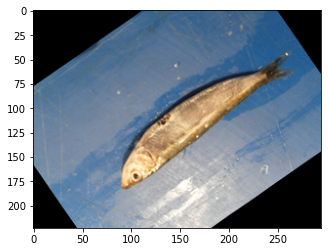

In [15]:
image = cv2.cvtColor(cv2.imread('img1.png'), cv2.COLOR_BGR2RGB)
plt.imshow(image, cmap='gray')
plt.show()

In [16]:
data = np.array(image.reshape((-1,3)))

In [17]:
image.shape

(223, 295, 3)

In [18]:
import copy

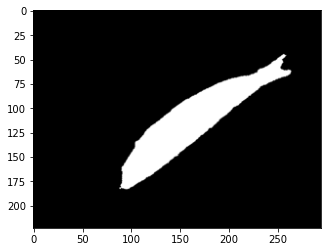

In [19]:
mask = cv2.cvtColor(cv2.imread('mask1.png'), cv2.COLOR_BGR2RGB)
plt.imshow(mask, cmap='gray')
plt.show()

In [20]:
import copy
errors = []
kmeans = KMeans(3)
errors.append(kmeans.fit(copy.deepcopy(data)))

    #Make the classify for every point in the original image and substitute the color with the result of classify()
segmented_data = kmeans.classify()


  6%|▌         | 6/100 [00:00<00:01, 55.19it/s]

[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]


100%|██████████| 65785/65785 [01:48<00:00, 606.15it/s]


In [21]:
errors

[([6432554133902.23,
   711345552726.4724,
   543461348459.3038,
   515391729064.5692,
   508868873064.6825,
   506862318325.44977,
   506268604635.13416,
   506124444702.23846,
   506099787249.2194],
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))]

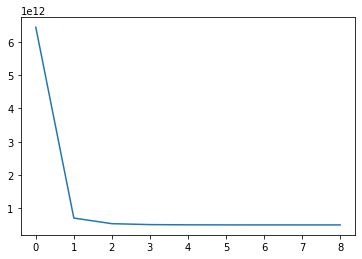

In [22]:
plt.plot(errors[0][0])

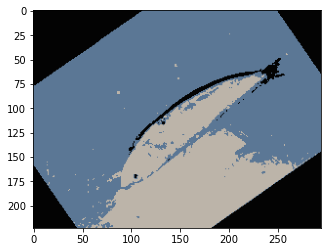

In [23]:
segmented_image = segmented_data.reshape((223, 295, 3)) # reshape data into the original image dimensions
plt.figure()
plt.imshow(segmented_image)

In [24]:
uniq_colors = np.unique(segmented_image.reshape(-1,3), axis=0)


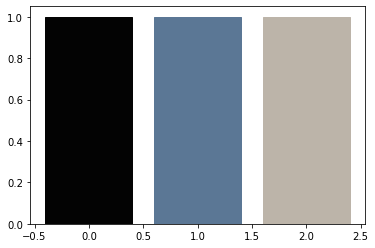

In [25]:
barlist=plt.bar([i for i in range(len(uniq_colors))], 1)
for i in range(len(uniq_colors)):
    barlist[i].set_color((uniq_colors[i]/255))
plt.show()

In [26]:
data = np.array(segmented_data.reshape((-1,3)))

In [27]:
a = (data == uniq_colors[2] * 1).reshape((223, 295, 3))

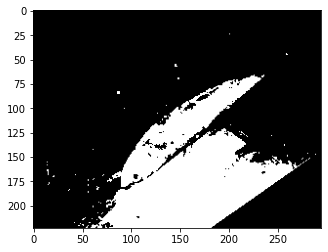

In [28]:
plt.figure()
a = a * 255
plt.imshow(a)

In [29]:
pred_mask = cv2.cvtColor(np.float32(a), cv2.COLOR_BGR2GRAY)

In [30]:
pred_mask.shape

(223, 295)

In [31]:
pred_mask = pred_mask/255
mask = mask/255

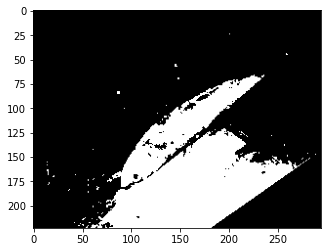

In [32]:
plt.figure()
plt.imshow(pred_mask, cmap='gray')

In [33]:
pred_mask.shape

(223, 295)

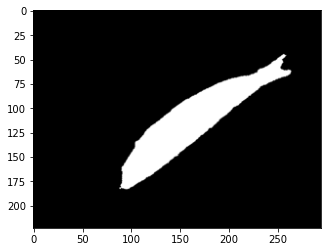

In [34]:
plt.figure()
plt.imshow(mask, cmap='gray')

In [35]:
mask = cv2.cvtColor(np.float32(mask), cv2.COLOR_BGR2GRAY)

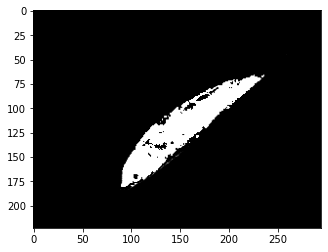

In [36]:
#Overlap
plt.figure()
plt.imshow(mask * pred_mask, cmap='gray')

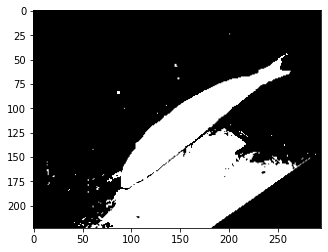

In [38]:
#Union
plt.figure()
plt.imshow(((mask + pred_mask) >= 1)**2, cmap='gray')

In [39]:
#write metrics with numpy (formulas are fiven in the presentation)

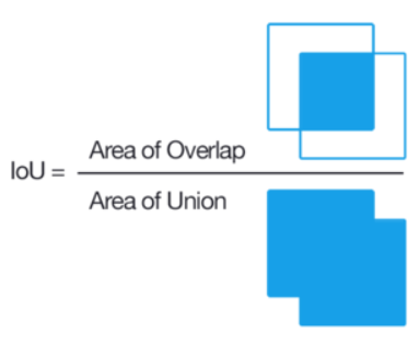

In [56]:
def IoU(mask, pred_mask):
    iou = np.sum(mask * pred_mask)/np.sum(mask + pred_mask)
    return iou

In [50]:
IoU(mask, pred_mask)

0.20375244

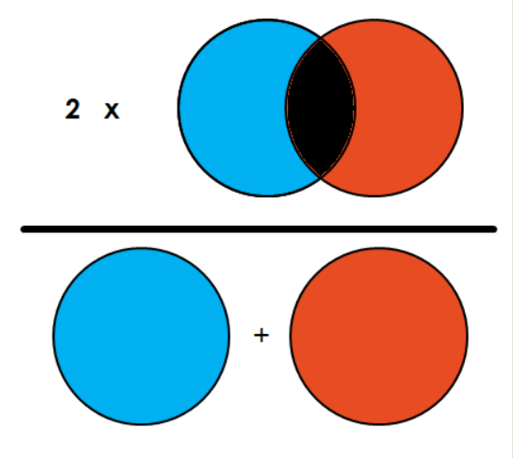

In [63]:
def dice(mask, pred_mask):
    dice=(2*np.sum(mask * pred_mask))/(np.sum(mask) + np.sum(pred_mask))
    return dice

In [64]:
dice(mask, pred_mask)

0.4075048887335176

  0%|          | 59/65785 [00:00<01:52, 585.71it/s]

[[3 3 3]
 [3 3 3]
 [3 3 3]
 ...
 [3 3 3]
 [3 3 3]
 [3 3 3]]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\YESBOL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\YESBOL\anaconda3\lib\site-packages\numpy\core\_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
  3%|▎         | 3/100 [00:00<00:04, 23.50it/s]

[([12621467613370.078], array([0, 1, 2]))]
[[3 3 3]
 [3 3 3]
 [3 3 3]
 ...
 [3 3 3]
 [3 3 3]
 [3 3 3]]


  2%|▏         | 2/100 [00:00<00:05, 18.91it/s]

[([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]))]
[[3 3 3]
 [3 3 3]
 [3 3 3]
 ...
 [3 3 3]
 [3 3 3]
 [3 3 

100%|██████████| 65785/65785 [01:47<00:00, 610.81it/s]


[([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]))]


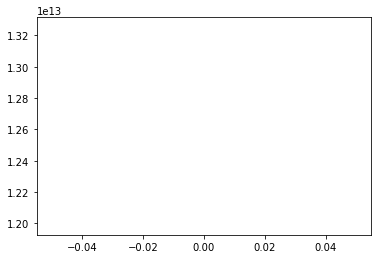

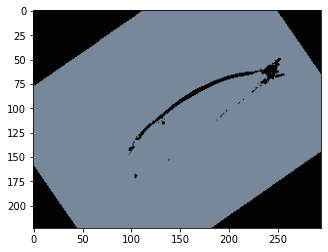

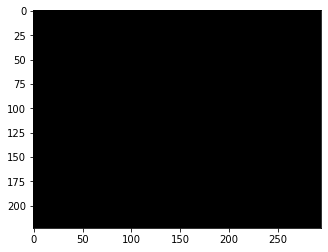

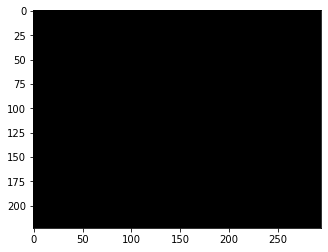

In [65]:
#k number of clasters
for k in [2,5,10]:
    errors = []
    kmeans = KMeans(k)
    errors.append(kmeans.fit(copy.deepcopy(data)))

    #Make the classify for every point in the original image and substitute the color with the result of classify()
    segmented_data = kmeans.classify()
    print(errors)
    plt.plot(errors[0][0])
    segmented_image = segmented_data.reshape((223, 295, 3)) # reshape data into the original image dimensions
    plt.figure()
    plt.imshow(segmented_image)
    #apply kmeans algorithm given you 
    #output - segmentated image with number of colors depends on k

In [ ]:
#get binary mask for each type of clusters

In [ ]:
import copy
errors = []
kmeans = KMeans(3)
errors.append(kmeans.fit(copy.deepcopy(data)))

    #Make the classify for every point in the original image and substitute the color with the result of classify()
segmented_data = kmeans.classify()


In [ ]:
#calculate dice and IoU metrics for each binary mask 
#provide your descritpiton in which case k means algorithms works better 